# Wild Blueberry Yield Prediction

## Importing the required Libraries

In [25]:
# Importing general libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import shap

#Feature enginerring libraries
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression, mutual_info_regression
from sklearn.model_selection import train_test_split

#Model preparation libraries
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import RepeatedKFold

#Model evaluation libraries
from sklearn import metrics
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error

#Model hyperparameter tuning
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

#Additional imports

import joblib
%matplotlib inline



# Importing Data and Preprocessing


According to data dictionary, we have 3 unknown fields, <b>fruitset, fruitmass, seeds</b> having high correlation values with the target varialble, the <b>yield</b> value.

1. we have a data dictionary of mutual correlated values of each of the fields with yield values
2. as this clearly is a regression problem, we can perform feature selection on the data
3. there are the following approaches:
    * f_regression() parameter for selecting by correlation
    * mutual_info_regression() for selecting by information gain
    * raw data features kept intact

In [8]:
#Loading the Data
berry_data = pd.read_csv(r"D:\Wild_Blueberry_Yield_Prediction\src\data\WildBlueberryPollinationSimulationData.csv")

#Printing 25 rows
print(berry_data.head(20))

    Row#  clonesize  honeybee  bumbles  andrena  osmia  MaxOfUpperTRange   
0      0       37.5      0.75     0.25     0.25   0.25              86.0  \
1      1       37.5      0.75     0.25     0.25   0.25              86.0   
2      2       37.5      0.75     0.25     0.25   0.25              94.6   
3      3       37.5      0.75     0.25     0.25   0.25              94.6   
4      4       37.5      0.75     0.25     0.25   0.25              86.0   
5      5       37.5      0.75     0.25     0.25   0.25              86.0   
6      6       37.5      0.75     0.25     0.25   0.25              94.6   
7      7       37.5      0.75     0.25     0.25   0.25              94.6   
8      8       37.5      0.75     0.25     0.25   0.25              77.4   
9      9       37.5      0.75     0.25     0.25   0.25              77.4   
10    10       37.5      0.75     0.25     0.25   0.25              69.7   
11    11       37.5      0.25     0.25     0.25   0.25              86.0   
12    12    

In [9]:
#Checking for metadata
print(berry_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 777 entries, 0 to 776
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Row#                  777 non-null    int64  
 1   clonesize             777 non-null    float64
 2   honeybee              777 non-null    float64
 3   bumbles               777 non-null    float64
 4   andrena               777 non-null    float64
 5   osmia                 777 non-null    float64
 6   MaxOfUpperTRange      777 non-null    float64
 7   MinOfUpperTRange      777 non-null    float64
 8   AverageOfUpperTRange  777 non-null    float64
 9   MaxOfLowerTRange      777 non-null    float64
 10  MinOfLowerTRange      777 non-null    float64
 11  AverageOfLowerTRange  777 non-null    float64
 12  RainingDays           777 non-null    float64
 13  AverageRainingDays    777 non-null    float64
 14  fruitset              777 non-null    float64
 15  fruitmass             7

#### Observations-
##### 1)The dataframe has a total of 777 entries (rows) and 18 columns.
##### 2)The data types of the columns are mostly float64 (17      columns) and one column is of type int64 ("Row#").
##### 3)All columns have a non-null count of 777, indicating that there are no missing values in the dataframe.
##### 4)The memory usage of the dataframe is approximately 109.4 KB.

In [17]:
#Checking for Null values
print(berry_data.isna().sum().sort_values(ascending=False))

Row#                    0
clonesize               0
seeds                   0
fruitmass               0
fruitset                0
AverageRainingDays      0
RainingDays             0
AverageOfLowerTRange    0
MinOfLowerTRange        0
MaxOfLowerTRange        0
AverageOfUpperTRange    0
MinOfUpperTRange        0
MaxOfUpperTRange        0
osmia                   0
andrena                 0
bumbles                 0
honeybee                0
yield                   0
dtype: int64


In [16]:
#Checking for duplicates
print(berry_data.duplicated().sort_values(ascending=False))

0      False
534    False
512    False
513    False
514    False
       ...  
262    False
263    False
264    False
265    False
776    False
Length: 777, dtype: bool


In [13]:
#Checking for Stats description
print(berry_data.describe(include='all'))

             Row#   clonesize    honeybee     bumbles     andrena       osmia   
count  777.000000  777.000000  777.000000  777.000000  777.000000  777.000000  \
mean   388.000000   18.767696    0.417133    0.282389    0.468817    0.562062   
std    224.444871    6.999063    0.978904    0.066343    0.161052    0.169119   
min      0.000000   10.000000    0.000000    0.000000    0.000000    0.000000   
25%    194.000000   12.500000    0.250000    0.250000    0.380000    0.500000   
50%    388.000000   12.500000    0.250000    0.250000    0.500000    0.630000   
75%    582.000000   25.000000    0.500000    0.380000    0.630000    0.750000   
max    776.000000   40.000000   18.430000    0.585000    0.750000    0.750000   

       MaxOfUpperTRange  MinOfUpperTRange  AverageOfUpperTRange   
count        777.000000        777.000000            777.000000  \
mean          82.277091         49.700515             68.723037   
std            9.193745          5.595769              7.676984   
mi

In [14]:
#Checking for unique values
print(berry_data.nunique().sort_values(ascending=False))

Row#                    777
fruitset                777
seeds                   777
fruitmass               777
yield                   777
osmia                    12
andrena                  12
bumbles                  10
honeybee                  7
clonesize                 6
MaxOfUpperTRange          5
MinOfUpperTRange          5
AverageOfUpperTRange      5
MinOfLowerTRange          5
AverageOfLowerTRange      5
RainingDays               5
AverageRainingDays        5
MaxOfLowerTRange          5
dtype: int64


# Univariate Analysis

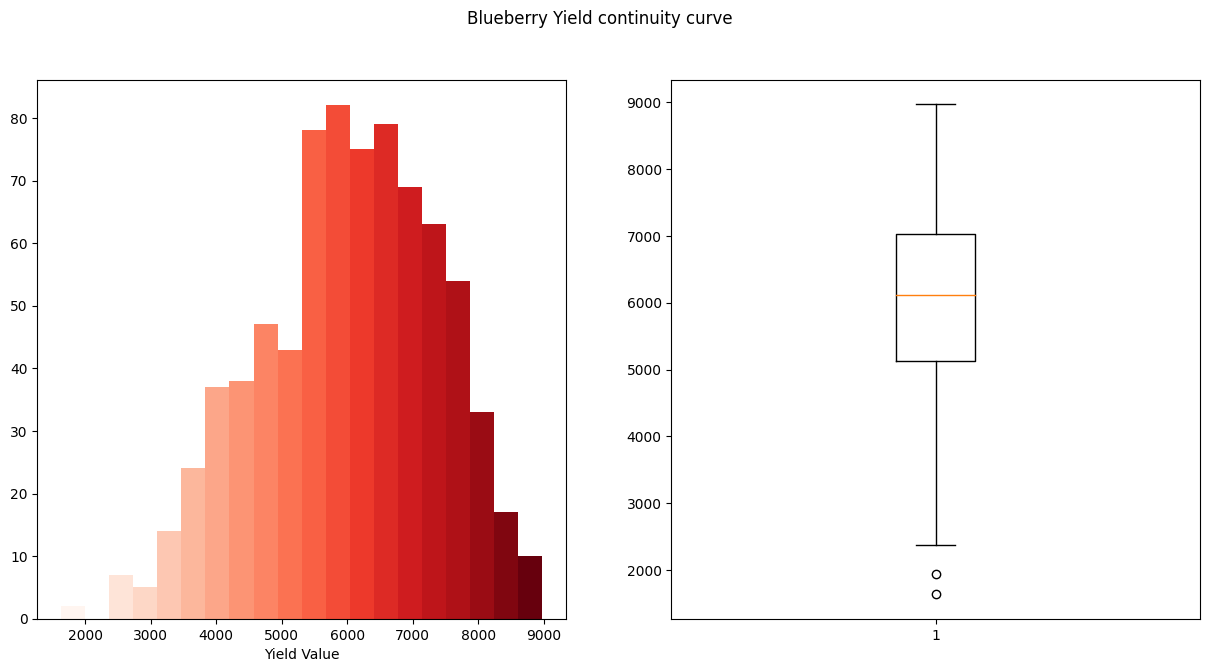

In [37]:
#Analysis


figs, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))
figs.suptitle("Blueberry Yield continuity curve")

# Histogram plot
x = berry_data["yield"]
n, bins, patches = ax1.hist(x, bins=20, color="salmon")

# Calculate gradient values
gradient = np.linspace(0, 1, len(patches))
for patch, color in zip(patches, gradient):
    patch.set_facecolor(plt.cm.Reds(color))

ax1.set_xlabel("Yield Value")

# Boxplot plot
ax2.boxplot(x)
vis_path =r"D:\Wild_Blueberry_Yield_Prediction\src\visualizations\Blueberry_Yield_continuity_curve.png"
plt.savefig(vis_path)
plt.show()
#Saving the figure


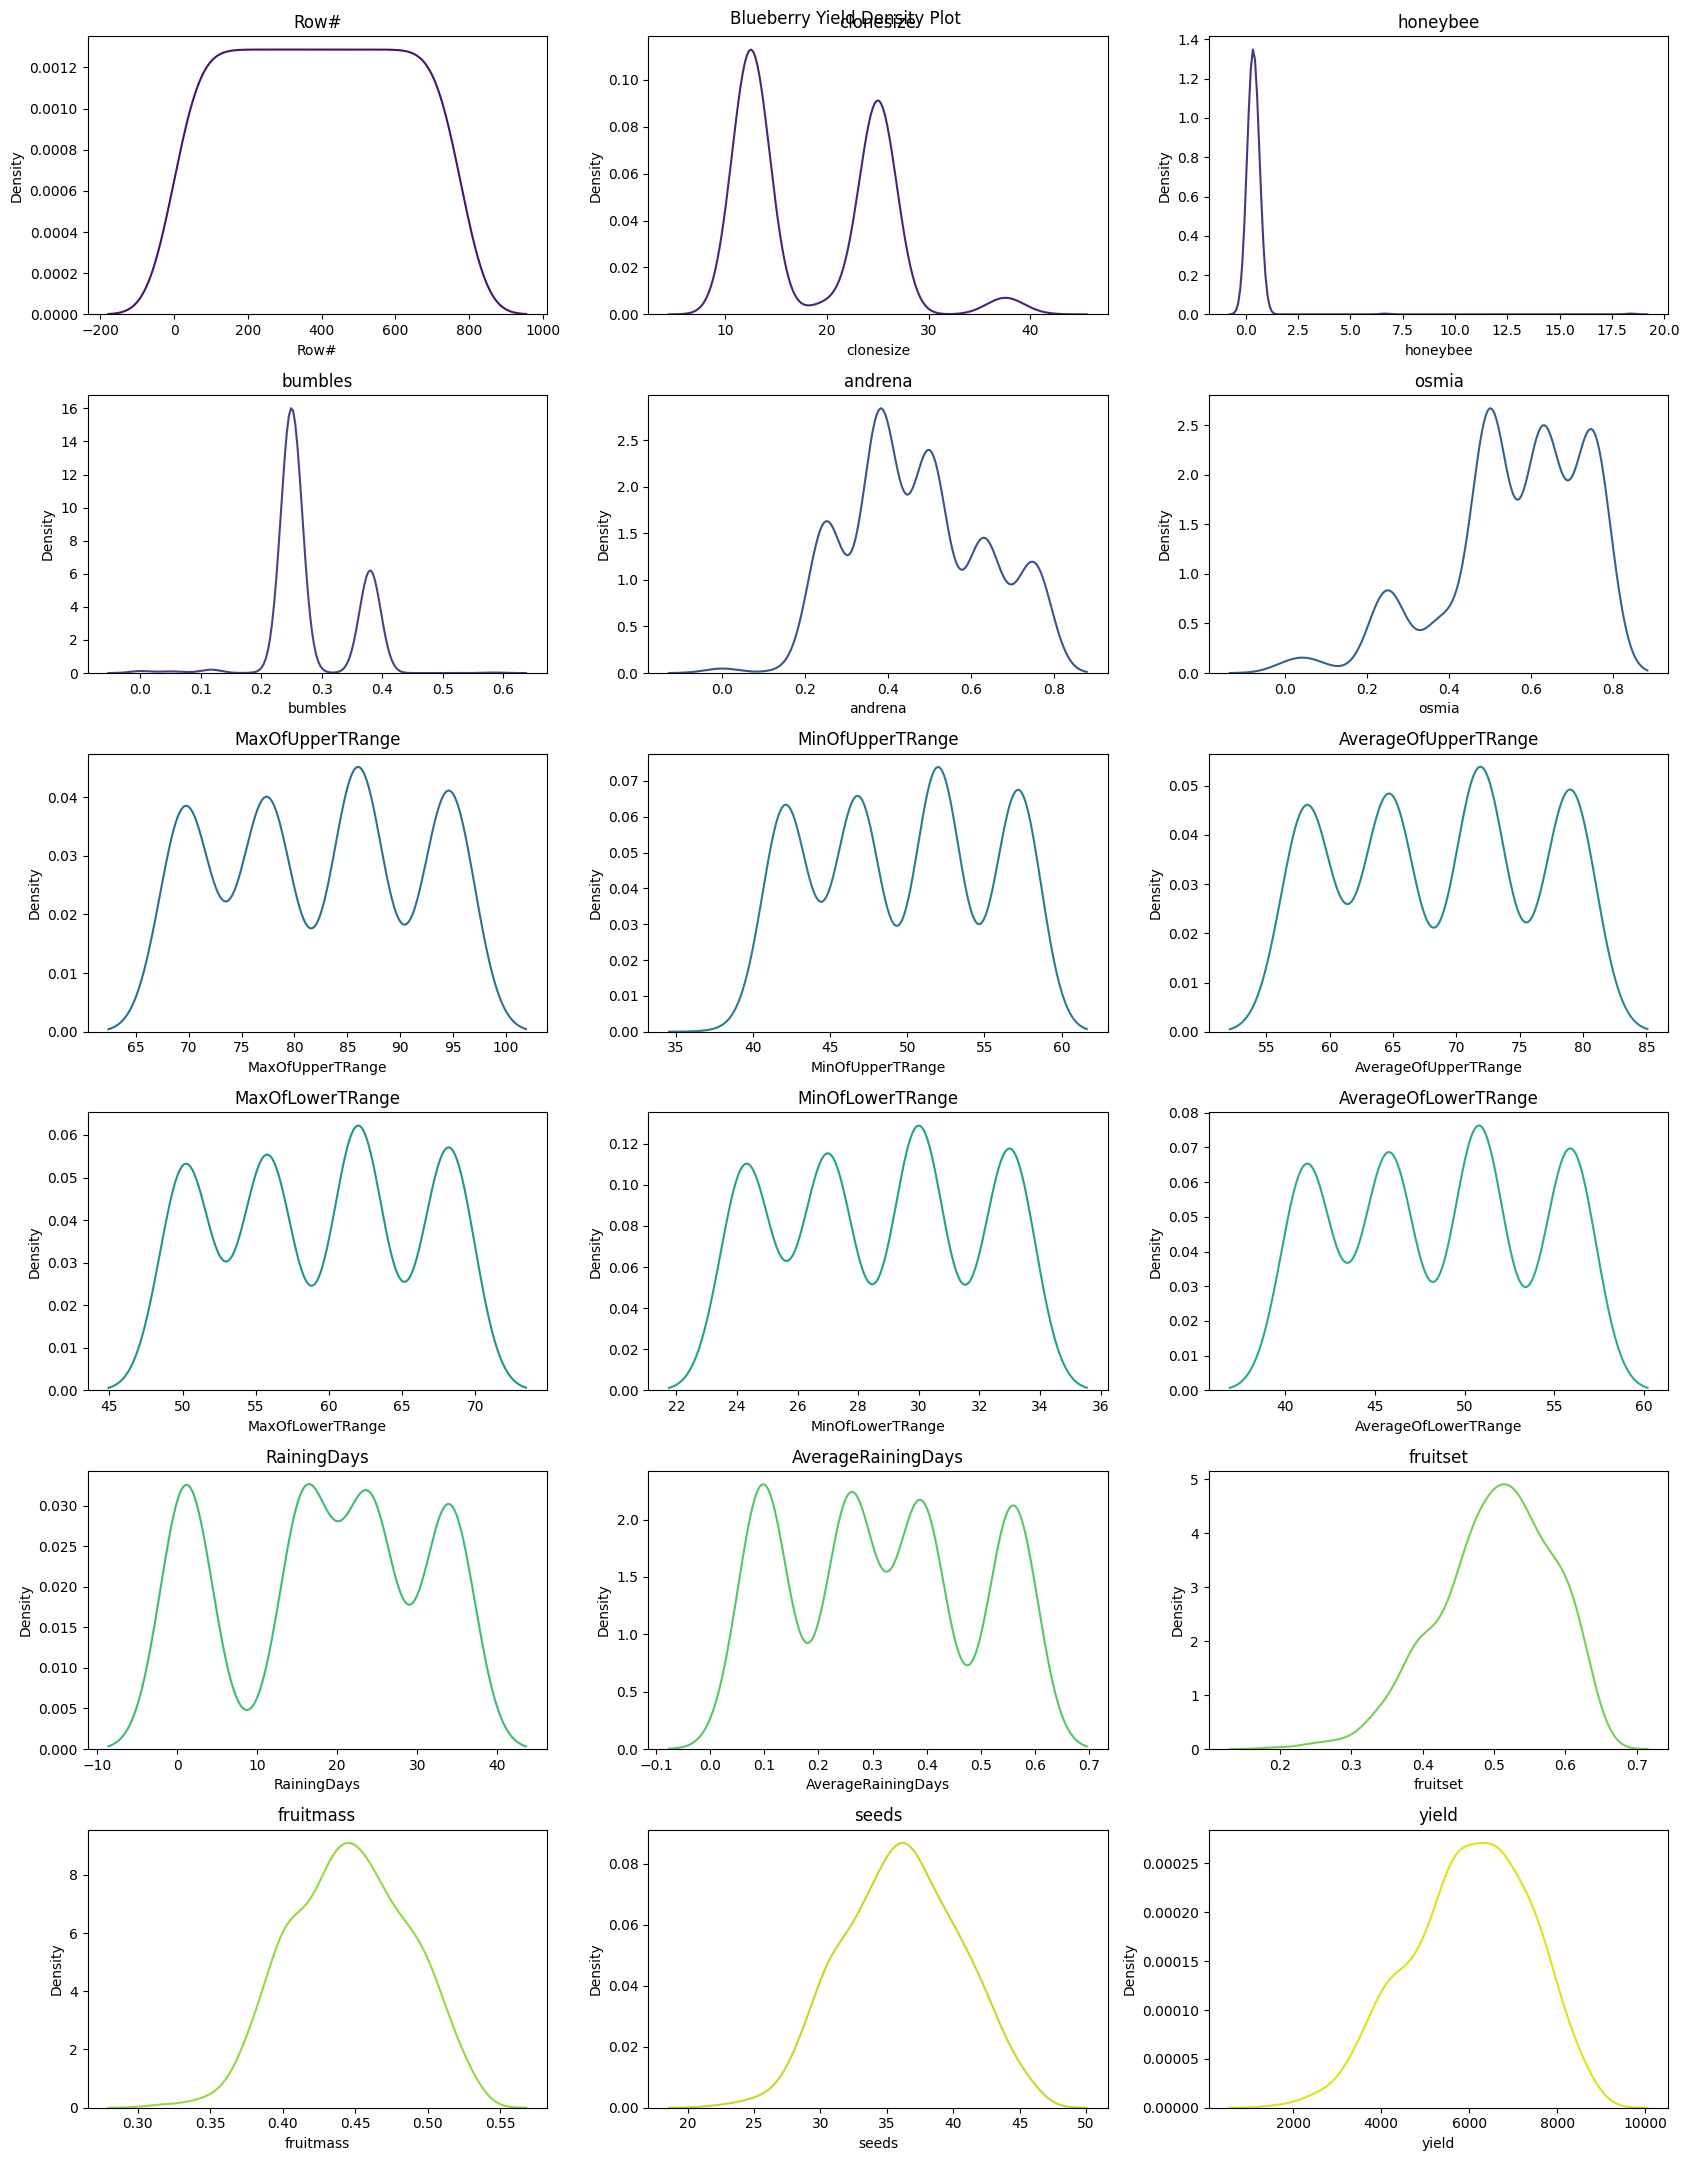

In [38]:
 #Density Plot
colors = sns.color_palette("viridis", len(berry_data.columns))

# Density plot
fig, axes = plt.subplots(6, 3, figsize=(17, 22))
fig.suptitle("Blueberry Yield Density Plot")

for i, (col, ax) in enumerate(zip(berry_data.columns, axes.flatten())):
    sns.kdeplot(data=berry_data, x=col, color=colors[i], ax=ax)
    ax.set_title(col)


vis_path2 =r"D:\Wild_Blueberry_Yield_Prediction\src\visualizations\Blueberry_Yield_Density_Plot.png"
plt.savefig(vis_path2)
plt.tight_layout()
plt.show()

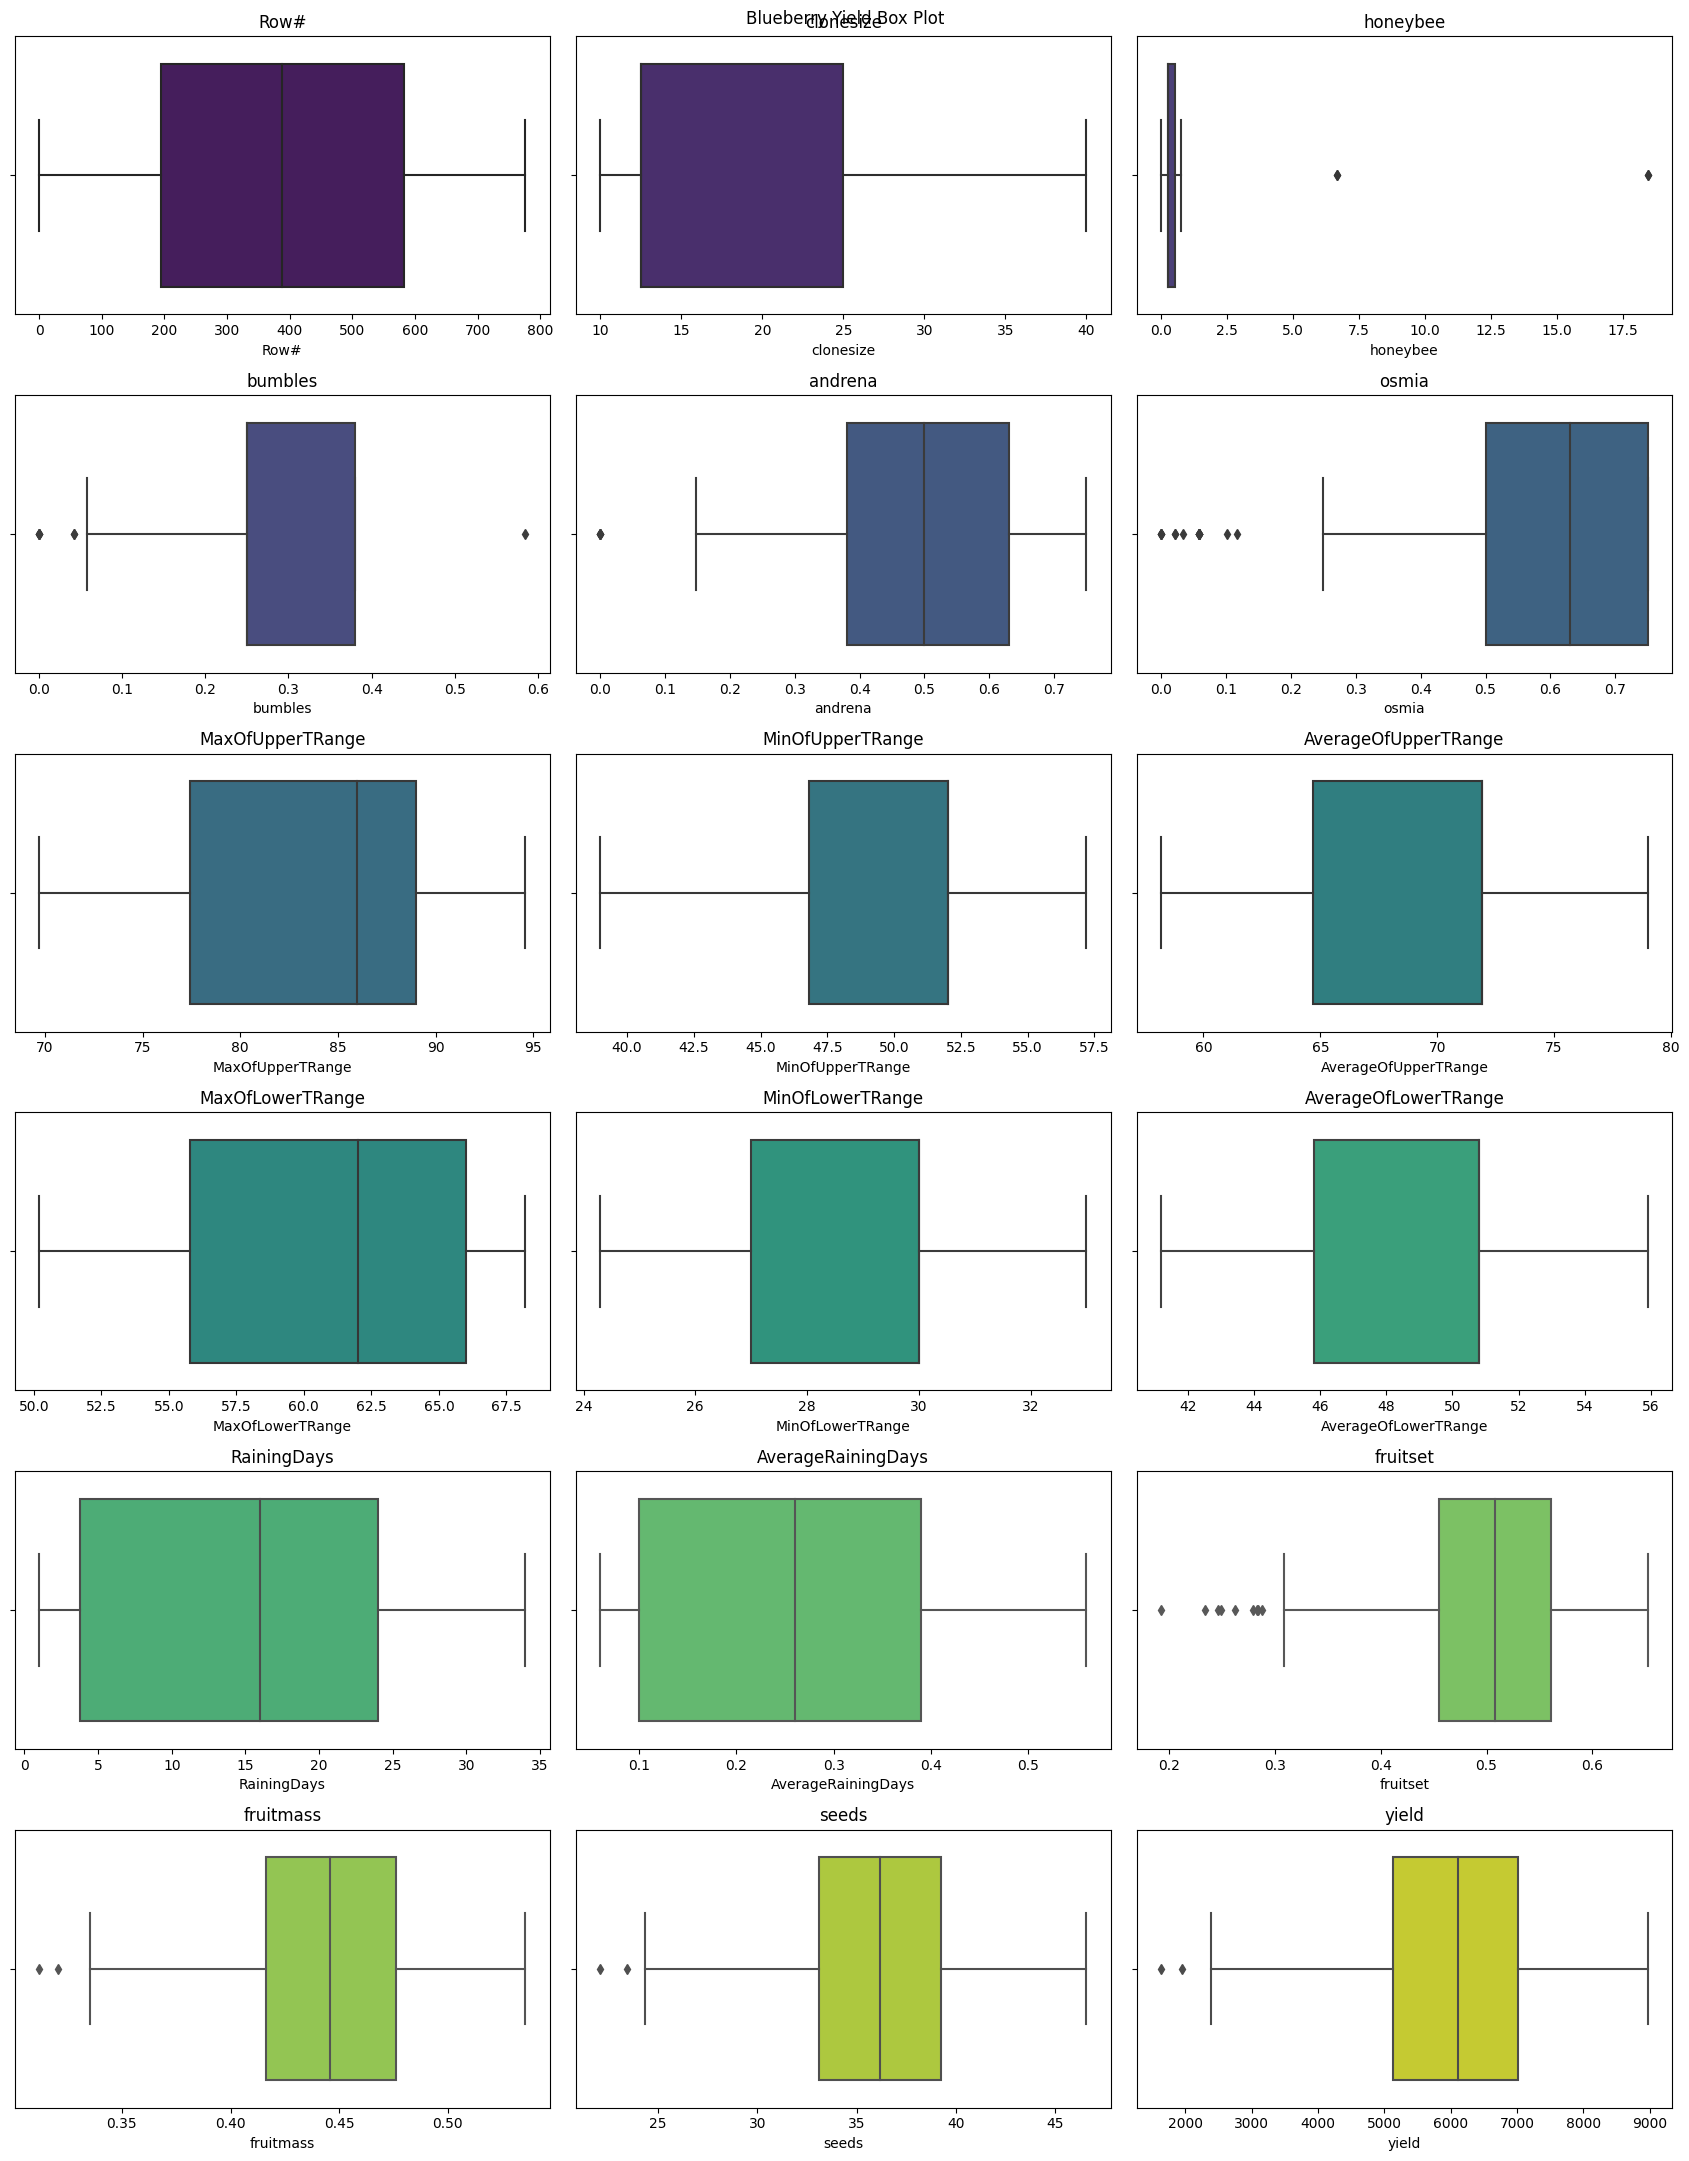

In [39]:
 #Density Plot
colors = sns.color_palette("viridis", len(berry_data.columns))

# Density plot
fig, axes = plt.subplots(6, 3, figsize=(17, 22))
fig.suptitle("Blueberry Yield Box Plot")

for i, (col, ax) in enumerate(zip(berry_data.columns, axes.flatten())):
    sns.boxplot(data=berry_data, x=col, color=colors[i], ax=ax)
    ax.set_title(col)


vis_path3 =r"D:\Wild_Blueberry_Yield_Prediction\src\visualizations\Blueberry_Yield_Box_Plot.png"
plt.savefig(vis_path3)
plt.tight_layout()
plt.show()

# Multivariate Analysis